# SAM8905 Interpreter Sandbox

Interactive environment for testing and debugging SAM8905 DSP algorithms.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## Basic Usage

Create an interpreter instance and run a simple sine wave generator.

In [3]:
sam = SAM8905Interpreter()

# Sinus Oscillator from Programmer's Guide:
# PHI=0    ; phase in D[0]
# DPHI=1   ; phase increment in D[1]
# AMP=2    ; amplitude and mix in D[2]
#
# RM   PHI,  <WA,WPHI,WSP>   ; A=PHI, PHI reg=D[0], WF=0x100 (sinus)
# RM   DPHI, <WB>            ; B=D[1] (phase increment)
# RM   AMP,  <WXY,WSP>       ; X=sin(PHI), Y=AMP, mix updated
# RADD PHI,  <WM>            ; D[0]=A+B (PHI+DPHI)
# RSP                        ; NOP (wait for multiplier)
# RSP       ,<WACC>          ; accumulate AMP x sin(PHI)

aram_sine = [
    0x016F,  # PC00: RM 0, <WA, WPHI, WSP>  - A=PHI, set internal sine
    0x08BF,  # PC01: RM 1, <WB>             - B=DPHI
    0x11F7,  # PC02: RM 2, <WXY, WSP>       - X=sin(PHI), Y=AMP, set mix
    0x02DF,  # PC03: RADD 0, <WM>           - D[0]=A+B (update phase)
    0x06FF,  # PC04: RSP                    - NOP (wait for multiplier)
    0x06FE,  # PC05: RSP, <WACC>            - accumulate result
] + [0x7FFF] * 26  # Fill rest with NOPs

sam.load_aram(aram_sine, offset=0)  # ALG 0

# D-RAM setup for slot 0:
# D[0] = PHI (phase) - starts at 0
# D[1] = DPHI (phase increment) - for 440Hz: 4096 * 440 / 44100 ≈ 41
# D[2] = AMP with mix bits - amplitude in upper bits, mix in lower
# D[15] = ALG=0, IDLE=0
phase_inc = int(4096 * 440 / 44100)  # ~41 for 440Hz
amplitude = 0x100  # Half amplitude (Q0.11)
mix_l, mix_r = 5, 5  # Full volume

dram_slot0 = [0] * 16
dram_slot0[0] = 0  # PHI starts at 0
dram_slot0[1] = phase_inc << 7  # DPHI in upper bits (bus[18:7] -> Y)
dram_slot0[2] = (amplitude << 7) | (mix_l << 3) | mix_r  # AMP + mix
dram_slot0[15] = 0x00000  # ALG=0, IDLE=0

sam.load_dram(0, dram_slot0)

print("Loaded sinus oscillator for 440Hz (from programmer's guide)")

Loaded sinus oscillator for 440Hz (from programmer's guide)


Generated 2000 samples
L range: [-5884, 5884]
R range: [-5884, 5884]


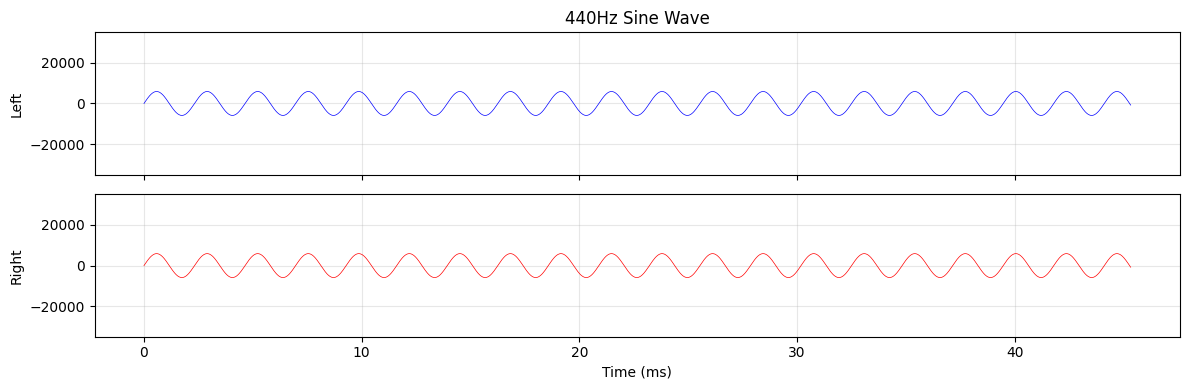

In [4]:
# Generate 2000 samples (~45ms at 44.1kHz)
samples = sam.run(2000, active_slots=[0])

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")

plot_waveform(samples, title="440Hz Sine Wave")
plt.show()

## State Inspection

Examine registers and D-RAM after execution.

In [13]:
print_state(sam.state, slot=0)

SAM8905 Register State
  A = 0x42C00  (-250880)
  B = 0x01400  (+5120)
  X = 0xF39  (-199)
  Y = 0x100  (+256)
  PHI = 0x858  (2136)
  WF = 0x100
  MUL = 0x7F390  (-3184)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = -3184  R_ACC = -3184

D-RAM Slot 0:
  D[ 0] = 0x44000  (-245760)
  D[ 1] = 0x01400  (+5120)
  D[ 2] = 0x0803F  (+32831)
  D[ 3] = 0x00000  (+0)
  D[ 4] = 0x00000  (+0)
  D[ 5] = 0x00000  (+0)
  D[ 6] = 0x00000  (+0)
  D[ 7] = 0x00000  (+0)
  D[ 8] = 0x00000  (+0)
  D[ 9] = 0x00000  (+0)
  D[10] = 0x00000  (+0)
  D[11] = 0x00000  (+0)
  D[12] = 0x00000  (+0)
  D[13] = 0x00000  (+0)
  D[14] = 0x00000  (+0)
  D[15] = 0x00000  (+0)


In [ ]:
# Get state as dictionary
snap = sam.get_state_snapshot()
print(f"PHI = {snap['phi']} (0x{snap['phi']:03X})")
print(f"X = {snap['x']}")
print(f"Y = {snap['y']}")
print(f"MUL = {snap['mul_result']}")

## Instruction Tracing

Enable tracing to see instruction-by-instruction execution.

In [ ]:
# Reset and enable tracing
sam.reset()
sam.load_aram(aram_sine, offset=0)
sam.load_dram(0, dram_slot0)

sam.trace_enabled = True
sam.trace_output = []

# Run just 3 frames
samples = sam.run(3, active_slots=[0])

print("Instruction trace:")
for line in sam.trace_output:
    print(line)

## Keyfox10 Reverb Algorithm (ALG 2)

Load and examine the reverb algorithm from the Keyfox10.

In [ ]:
# ALG 2 from Keyfox10 A-RAM dump
aram_alg2 = [
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF
]

# Disassemble
print(decode_algorithm(aram_alg2, 2))

In [ ]:
# D-RAM configuration for FX slot (slot 4 in Keyfox10)
dram_slot4 = [
    0x00000,  # word 0: Zero constant (Y init, PHI reset)
    0x50080,  # word 1: SRAM address config (WF=0x50, PHI base)
    0x00400,  # word 2: SRAM read address for final output
    0x40000,  # word 3: Phase offset = -262144 (most negative 19-bit)
    0x00080,  # word 4: Working register (gets cleared at PC46)
    0x00000,  # word 5: Delayed sample accumulator
    0x7FFFF,  # word 6: -1 constant (val=-1, for saturation check)
    0x40402,  # word 7: SRAM bank select config
    0x00100,  # word 8: Delay line base pointer
    0x00080,  # word 9: Delay increment 1
    0x00180,  # word 10: Delay increment 2
    0x0007C,  # word 11: Signal amplitude state [val=124, doubles to 248]
    0x00000,  # word 12: Initial A value (added to D[11])
    0x00000,  # word 13: Working buffer / final output destination
    0x00000,  # word 14: Product storage
    0x34080,  # word 15: SRAM config + IDLE=0, ALG=2
]

print("D-RAM slot 4 configuration:")
for i, val in enumerate(dram_slot4):
    print(f"  D[{i:2d}] = 0x{val:05X}")

## Export to WAV

Save generated samples to a WAV file.

In [ ]:
# Generate longer sample
sam.reset()
sam.load_aram(aram_sine, offset=0)
sam.load_dram(0, dram_slot0)

samples = sam.run(44100, active_slots=[0])  # 1 second

# Export
export_wav(samples, 'sine_440hz_test.wav')

## Custom Algorithm Development

Template for developing new algorithms.

In [ ]:
# Build instruction helper
def make_inst(mad=0, emitter='RM', wsp=False,
              wa=False, wb=False, wm=False, wphi=False, wxy=False,
              clear_b=False, wwf=False, wacc=False):
    """Build a 15-bit instruction word."""
    emitter_map = {'RM': 0, 'RADD': 1, 'RP': 2, 'RSP': 3}
    inst = (mad & 0xF) << 11
    inst |= emitter_map[emitter] << 9
    inst |= 0x100 if wsp else 0
    # Active-low receivers
    if not wa: inst |= 0x80
    if not wb: inst |= 0x40
    if not wm: inst |= 0x20
    if not wphi: inst |= 0x10
    if not wxy: inst |= 0x08
    if not clear_b: inst |= 0x04
    if not wwf: inst |= 0x02
    if not wacc: inst |= 0x01
    return inst

# Example: build the sinus oscillator using the helper
# PHI=0, DPHI=1, AMP=2
custom_aram = [
    make_inst(mad=0, emitter='RM', wa=True, wphi=True, wsp=True),   # A=PHI, set sine
    make_inst(mad=1, emitter='RM', wb=True),                         # B=DPHI
    make_inst(mad=2, emitter='RM', wxy=True, wsp=True),              # X=sin, Y=AMP, mix
    make_inst(mad=0, emitter='RADD', wm=True),                       # D[0]=A+B
    make_inst(emitter='RSP'),                                        # NOP
    make_inst(emitter='RSP', wacc=True),                             # accumulate
] + [0x7FFF] * 26

print("Custom algorithm (sinus oscillator):")
print(decode_algorithm(custom_aram))